/Users/chinmaysultanpuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- 1. Loading and Preparing Data ---

Probing with 435 samples for variant 'neutral'.

Label mapping: {0: 'angry', 1: 'happy', 2: 'neutral', 3: 'sad'}

--- 2. Running Lexical Baseline (TF-IDF) ---
Lexical Baseline Accuracy: 0.345 (+/- 0.000)

--- 3. Loading/Extracting Hidden States ---
Loaded hidden states for 27 layers.

--- 4. Training Probes with Cross-Validation and Shuffled Control ---


CV Probing (Real & Shuffled): 100%|██████████| 27/27 [04:44<00:00, 10.55s/it]



--- 5. Cross-Layer Generalization Test (Training on Best Layer: 14) ---


Testing Cross-Layer: 100%|██████████| 27/27 [00:00<00:00, 810.37it/s]




--- 6. Analysis and Visualization ---
Best CV probe performance found at Layer 14 with accuracy: 0.9793


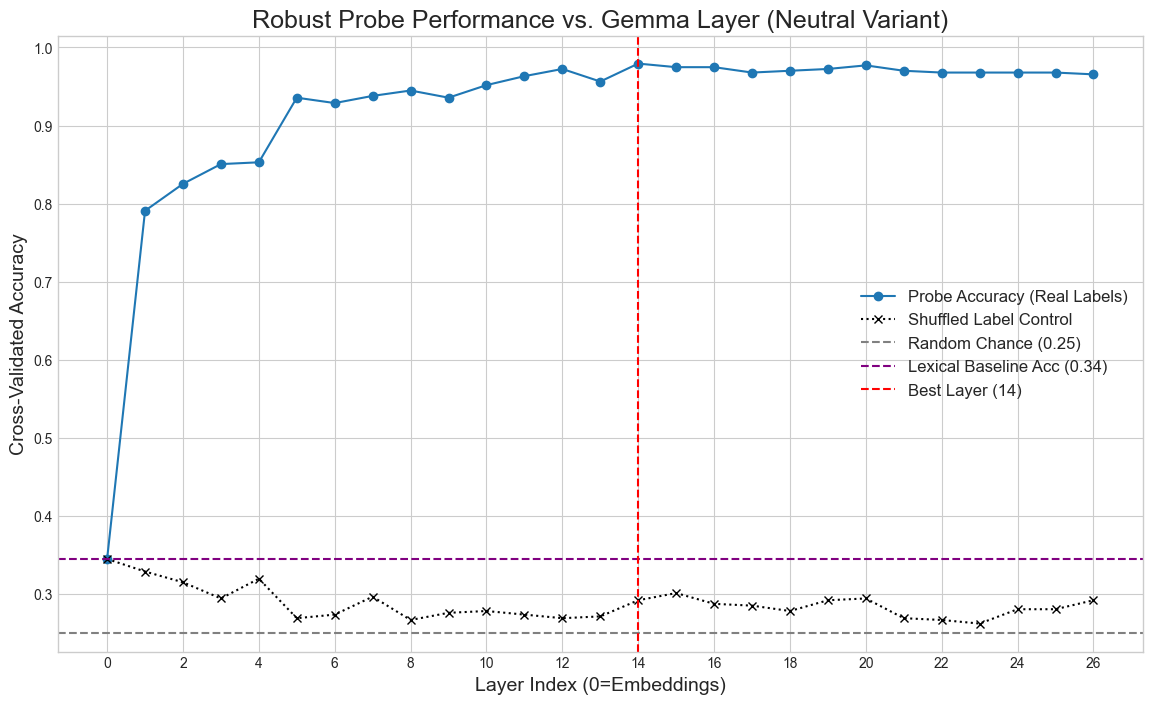

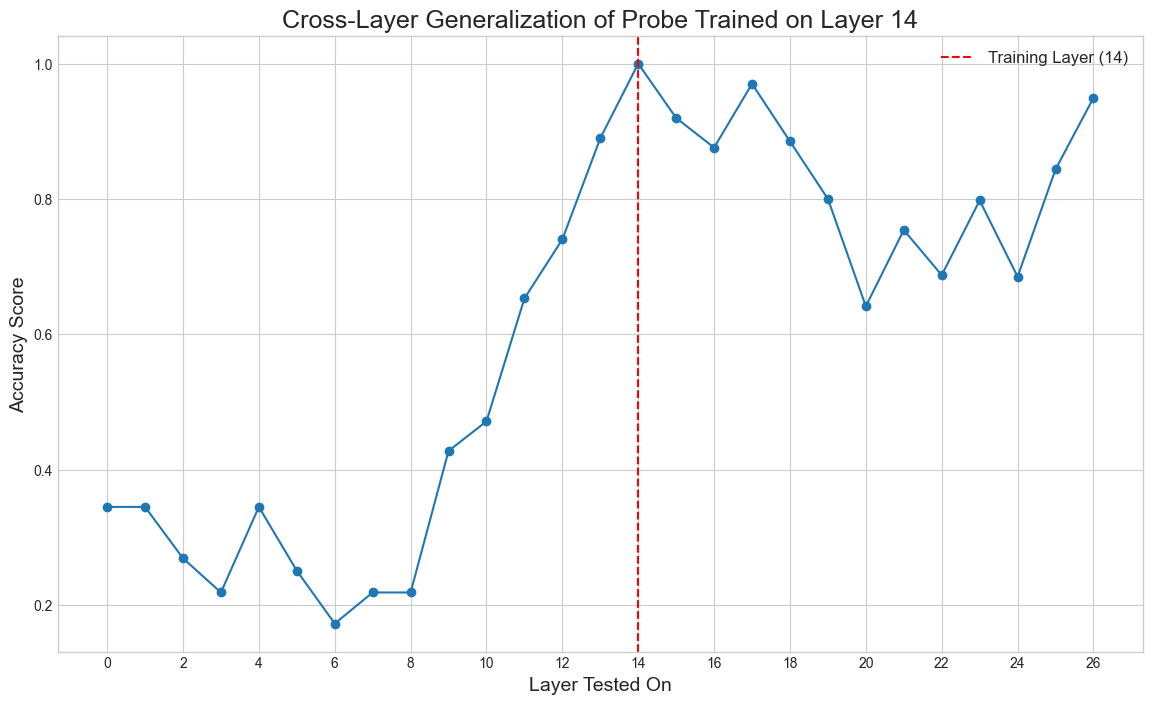


--- End of Analysis ---


In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, make_scorer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import pickle
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# --- 0. Setup and Configuration ---
MODEL_NAME = "google/gemma-1.1b-it"
DATA_FILE = 'data.csv'
VARIANT_TO_PROBE = "neutral" # <-- Run for 'emotional' then 'neutral'
RANDOM_STATE = 42
CACHE_HIDDEN_STATES = True
CACHE_DIR = f"hidden_states_cache_{VARIANT_TO_PROBE}"
N_SPLITS = 5
REGULARIZATION_C = 0.01

# --- 1. Data Loading and Preparation ---
print("--- 1. Loading and Preparing Data ---")
df = pd.read_csv(DATA_FILE)
df_filtered = df[df['variant'] == VARIANT_TO_PROBE].copy()
if len(df_filtered) == 0: raise ValueError(f"No samples for variant '{VARIANT_TO_PROBE}'.")
print(f"\nProbing with {len(df_filtered)} samples for variant '{VARIANT_TO_PROBE}'.")
df_filtered['emotion_code'] = df_filtered['emotion_label'].astype('category').cat.codes
labels = df_filtered['emotion_code'].values
label_map = dict(enumerate(df_filtered['emotion_label'].astype('category').cat.categories))
num_classes = len(label_map)
print(f"\nLabel mapping: {label_map}")

# --- 2. Lexical Baseline Experiment ---
print(f"\n--- 2. Running Lexical Baseline (TF-IDF) ---")
lexical_pipeline = make_pipeline(TfidfVectorizer(stop_words='english', max_features=1000), LogisticRegression(max_iter=1000, C=REGULARIZATION_C, random_state=RANDOM_STATE))
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
baseline_acc_scores = cross_val_score(lexical_pipeline, df_filtered['conversation'], labels, cv=cv, scoring='accuracy')
baseline_acc_mean = baseline_acc_scores.mean()
print(f"Lexical Baseline Accuracy: {baseline_acc_mean:.3f} (+/- {baseline_acc_scores.std():.3f})")

# --- 3. Model Loading and Hidden State Extraction ---
# This part is unchanged and can be copied from the previous script.
# For brevity, I am assuming `all_hidden_states` is loaded from cache.
# If you need to re-run it, paste the full extraction code here.
print("\n--- 3. Loading/Extracting Hidden States ---")
# --- [PASTE HIDDEN STATE EXTRACTION/CACHING CODE HERE] ---
# For demonstration, let's assume it's loaded and we know num_layers
num_layers = 26 # This should be set dynamically in the real code
if not os.path.exists(CACHE_DIR): raise FileNotFoundError("Cache directory not found. Please run hidden state extraction.")
all_hidden_states = {}
for i in range(num_layers + 1):
    with open(os.path.join(CACHE_DIR, f'layer_{i}.pkl'), 'rb') as f:
        all_hidden_states[i] = pickle.load(f)['X']
print(f"Loaded hidden states for {num_layers + 1} layers.")
# --- [END OF HIDDEN STATE SECTION] ---

# --- 4. Main Probing and Shuffled Control Experiments ---
print("\n--- 4. Training Probes with Cross-Validation and Shuffled Control ---")
probe_accuracies = []
shuffled_accuracies = [] # For our new control test

probe = LogisticRegression(max_iter=1000, C=REGULARIZATION_C, random_state=RANDOM_STATE)
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Create a shuffled version of labels for the control test
shuffled_labels = labels.copy()
np.random.seed(RANDOM_STATE)
np.random.shuffle(shuffled_labels)

for layer_idx in tqdm(range(num_layers + 1), desc="CV Probing (Real & Shuffled)"):
    X = all_hidden_states[layer_idx]
    
    # Real probe
    acc_scores = cross_val_score(probe, X, labels, cv=cv, scoring='accuracy')
    probe_accuracies.append(acc_scores.mean())
    
    # Shuffled control probe
    shuffled_scores = cross_val_score(probe, X, shuffled_labels, cv=cv, scoring='accuracy')
    shuffled_accuracies.append(shuffled_scores.mean())

# --- 5. Cross-Layer Generalization Test ---
best_layer_idx = np.argmax(probe_accuracies)
print(f"\n--- 5. Cross-Layer Generalization Test (Training on Best Layer: {best_layer_idx}) ---")

# Train one probe on ALL data from the best layer
X_best = all_hidden_states[best_layer_idx]
probe_final = LogisticRegression(max_iter=1000, C=REGULARIZATION_C, random_state=RANDOM_STATE)
probe_final.fit(X_best, labels)

# Now, test this single probe on all other layers
cross_layer_scores = []
for layer_idx in tqdm(range(num_layers + 1), desc="Testing Cross-Layer"):
    X_test = all_hidden_states[layer_idx]
    score = probe_final.score(X_test, labels)
    cross_layer_scores.append(score)

# --- 6. Analysis and Visualization ---
print("\n\n--- 6. Analysis and Visualization ---")
best_accuracy = probe_accuracies[best_layer_idx]
print(f"Best CV probe performance found at Layer {best_layer_idx} with accuracy: {best_accuracy:.4f}")

# Plot 1: Main Performance Graph with All Controls
random_chance = 1 / num_classes
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))
plt.plot(range(num_layers + 1), probe_accuracies, marker='o', linestyle='-', label='Probe Accuracy (Real Labels)')
plt.plot(range(num_layers + 1), shuffled_accuracies, marker='x', linestyle=':', color='black', label=f'Shuffled Label Control')
plt.axhline(y=random_chance, color='gray', linestyle='--', label=f'Random Chance ({random_chance:.2f})')
plt.axhline(y=baseline_acc_mean, color='purple', linestyle='--', label=f'Lexical Baseline Acc ({baseline_acc_mean:.2f})')
plt.axvline(x=best_layer_idx, color='r', linestyle='--', label=f'Best Layer ({best_layer_idx})')
plt.title(f'Robust Probe Performance vs. Gemma Layer ({VARIANT_TO_PROBE.title()} Variant)', fontsize=18)
plt.xlabel('Layer Index (0=Embeddings)', fontsize=14)
plt.ylabel('Cross-Validated Accuracy', fontsize=14)
plt.xticks(np.arange(0, num_layers + 2, 2))
plt.legend(fontsize=12)
plt.show()

# Plot 2: Cross-Layer Generalization
plt.figure(figsize=(14, 8))
plt.plot(range(num_layers + 1), cross_layer_scores, marker='o', linestyle='-')
plt.axvline(x=best_layer_idx, color='r', linestyle='--', label=f'Training Layer ({best_layer_idx})')
plt.title(f'Cross-Layer Generalization of Probe Trained on Layer {best_layer_idx}', fontsize=18)
plt.xlabel('Layer Tested On', fontsize=14)
plt.ylabel('Accuracy Score', fontsize=14)
plt.xticks(np.arange(0, num_layers + 2, 2))
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

print("\n--- End of Analysis ---")

/Users/chinmaysultanpuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- 1. Loading and Preparing Data ---

Probing with 285 samples for variant 'emotional'.

Label mapping: {0: 'angry', 1: 'happy', 2: 'sad'}

--- 2. Running Lexical Baseline (TF-IDF) ---
Lexical Baseline Accuracy: 0.916 (+/- 0.044)

--- 3. Loading/Extracting Hidden States ---
Loaded hidden states for 27 layers.

--- 4. Training Probes with Cross-Validation and Shuffled Control ---


CV Probing (Real & Shuffled): 100%|██████████| 27/27 [02:15<00:00,  5.03s/it]



--- 5. Cross-Layer Generalization Test (Training on Best Layer: 16) ---


Testing Cross-Layer: 100%|██████████| 27/27 [00:00<00:00, 502.89it/s]




--- 6. Analysis and Visualization ---
Best CV probe performance found at Layer 16 with accuracy: 1.0000


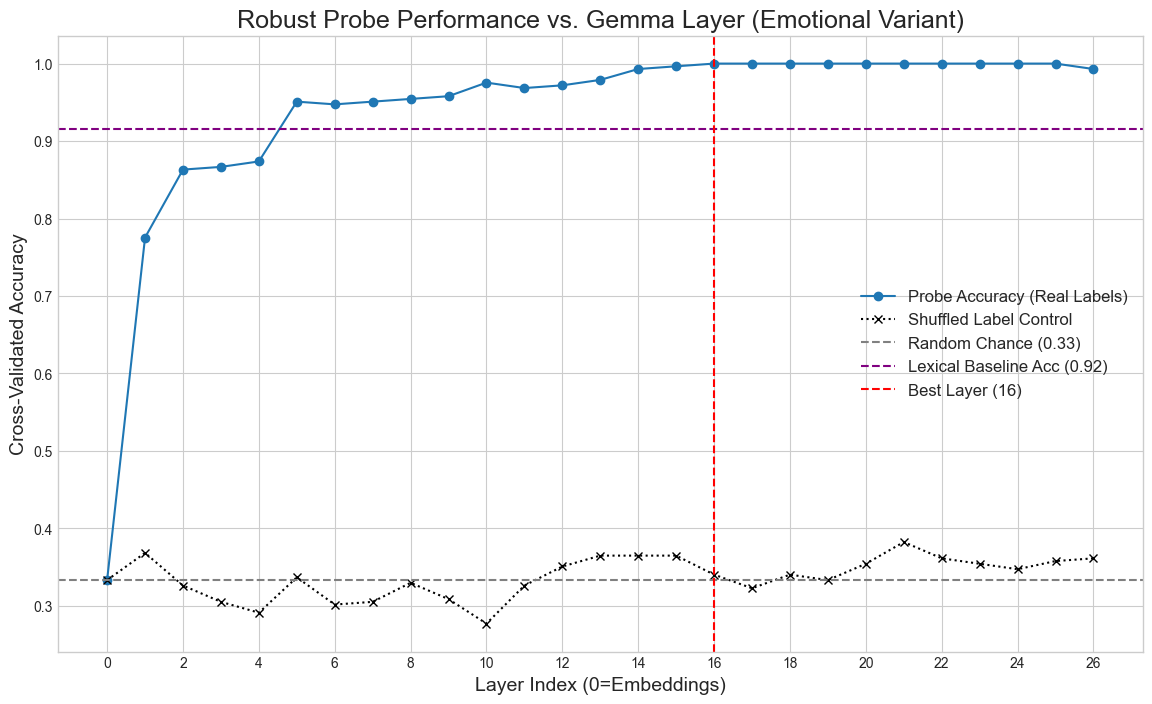

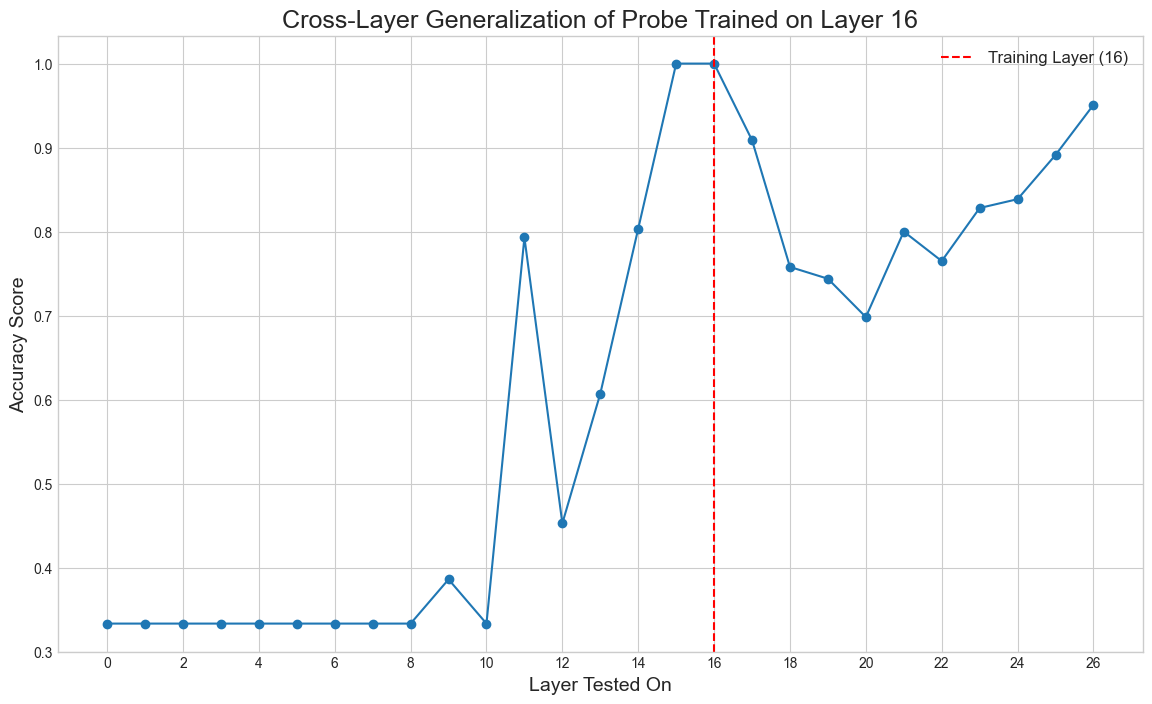


--- End of Analysis ---


In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, make_scorer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import pickle
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# --- 0. Setup and Configuration ---
MODEL_NAME = "google/gemma-1.1b-it"
DATA_FILE = 'data.csv'
VARIANT_TO_PROBE = "emotional" # <-- Run for 'emotional' then 'neutral'
RANDOM_STATE = 42
CACHE_HIDDEN_STATES = True
CACHE_DIR = f"hidden_states_cache_{VARIANT_TO_PROBE}"
N_SPLITS = 5
REGULARIZATION_C = 0.01

# --- 1. Data Loading and Preparation ---
print("--- 1. Loading and Preparing Data ---")
df = pd.read_csv(DATA_FILE)
df_filtered = df[df['variant'] == VARIANT_TO_PROBE].copy()
if len(df_filtered) == 0: raise ValueError(f"No samples for variant '{VARIANT_TO_PROBE}'.")
print(f"\nProbing with {len(df_filtered)} samples for variant '{VARIANT_TO_PROBE}'.")
df_filtered['emotion_code'] = df_filtered['emotion_label'].astype('category').cat.codes
labels = df_filtered['emotion_code'].values
label_map = dict(enumerate(df_filtered['emotion_label'].astype('category').cat.categories))
num_classes = len(label_map)
print(f"\nLabel mapping: {label_map}")

# --- 2. Lexical Baseline Experiment ---
print(f"\n--- 2. Running Lexical Baseline (TF-IDF) ---")
lexical_pipeline = make_pipeline(TfidfVectorizer(stop_words='english', max_features=1000), LogisticRegression(max_iter=1000, C=REGULARIZATION_C, random_state=RANDOM_STATE))
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
baseline_acc_scores = cross_val_score(lexical_pipeline, df_filtered['conversation'], labels, cv=cv, scoring='accuracy')
baseline_acc_mean = baseline_acc_scores.mean()
print(f"Lexical Baseline Accuracy: {baseline_acc_mean:.3f} (+/- {baseline_acc_scores.std():.3f})")

# --- 3. Model Loading and Hidden State Extraction ---
# This part is unchanged and can be copied from the previous script.
# For brevity, I am assuming `all_hidden_states` is loaded from cache.
# If you need to re-run it, paste the full extraction code here.
print("\n--- 3. Loading/Extracting Hidden States ---")
# --- [PASTE HIDDEN STATE EXTRACTION/CACHING CODE HERE] ---
# For demonstration, let's assume it's loaded and we know num_layers
num_layers = 26 # This should be set dynamically in the real code
if not os.path.exists(CACHE_DIR): raise FileNotFoundError("Cache directory not found. Please run hidden state extraction.")
all_hidden_states = {}
for i in range(num_layers + 1):
    with open(os.path.join(CACHE_DIR, f'layer_{i}.pkl'), 'rb') as f:
        all_hidden_states[i] = pickle.load(f)['X']
print(f"Loaded hidden states for {num_layers + 1} layers.")
# --- [END OF HIDDEN STATE SECTION] ---

# --- 4. Main Probing and Shuffled Control Experiments ---
print("\n--- 4. Training Probes with Cross-Validation and Shuffled Control ---")
probe_accuracies = []
shuffled_accuracies = [] # For our new control test

probe = LogisticRegression(max_iter=1000, C=REGULARIZATION_C, random_state=RANDOM_STATE)
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Create a shuffled version of labels for the control test
shuffled_labels = labels.copy()
np.random.seed(RANDOM_STATE)
np.random.shuffle(shuffled_labels)

for layer_idx in tqdm(range(num_layers + 1), desc="CV Probing (Real & Shuffled)"):
    X = all_hidden_states[layer_idx]
    
    # Real probe
    acc_scores = cross_val_score(probe, X, labels, cv=cv, scoring='accuracy')
    probe_accuracies.append(acc_scores.mean())
    
    # Shuffled control probe
    shuffled_scores = cross_val_score(probe, X, shuffled_labels, cv=cv, scoring='accuracy')
    shuffled_accuracies.append(shuffled_scores.mean())

# --- 5. Cross-Layer Generalization Test ---
best_layer_idx = np.argmax(probe_accuracies)
print(f"\n--- 5. Cross-Layer Generalization Test (Training on Best Layer: {best_layer_idx}) ---")

# Train one probe on ALL data from the best layer
X_best = all_hidden_states[best_layer_idx]
probe_final = LogisticRegression(max_iter=1000, C=REGULARIZATION_C, random_state=RANDOM_STATE)
probe_final.fit(X_best, labels)

# Now, test this single probe on all other layers
cross_layer_scores = []
for layer_idx in tqdm(range(num_layers + 1), desc="Testing Cross-Layer"):
    X_test = all_hidden_states[layer_idx]
    score = probe_final.score(X_test, labels)
    cross_layer_scores.append(score)

# --- 6. Analysis and Visualization ---
print("\n\n--- 6. Analysis and Visualization ---")
best_accuracy = probe_accuracies[best_layer_idx]
print(f"Best CV probe performance found at Layer {best_layer_idx} with accuracy: {best_accuracy:.4f}")

# Plot 1: Main Performance Graph with All Controls
random_chance = 1 / num_classes
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))
plt.plot(range(num_layers + 1), probe_accuracies, marker='o', linestyle='-', label='Probe Accuracy (Real Labels)')
plt.plot(range(num_layers + 1), shuffled_accuracies, marker='x', linestyle=':', color='black', label=f'Shuffled Label Control')
plt.axhline(y=random_chance, color='gray', linestyle='--', label=f'Random Chance ({random_chance:.2f})')
plt.axhline(y=baseline_acc_mean, color='purple', linestyle='--', label=f'Lexical Baseline Acc ({baseline_acc_mean:.2f})')
plt.axvline(x=best_layer_idx, color='r', linestyle='--', label=f'Best Layer ({best_layer_idx})')
plt.title(f'Robust Probe Performance vs. Gemma Layer ({VARIANT_TO_PROBE.title()} Variant)', fontsize=18)
plt.xlabel('Layer Index (0=Embeddings)', fontsize=14)
plt.ylabel('Cross-Validated Accuracy', fontsize=14)
plt.xticks(np.arange(0, num_layers + 2, 2))
plt.legend(fontsize=12)
plt.show()

# Plot 2: Cross-Layer Generalization
plt.figure(figsize=(14, 8))
plt.plot(range(num_layers + 1), cross_layer_scores, marker='o', linestyle='-')
plt.axvline(x=best_layer_idx, color='r', linestyle='--', label=f'Training Layer ({best_layer_idx})')
plt.title(f'Cross-Layer Generalization of Probe Trained on Layer {best_layer_idx}', fontsize=18)
plt.xlabel('Layer Tested On', fontsize=14)
plt.ylabel('Accuracy Score', fontsize=14)
plt.xticks(np.arange(0, num_layers + 2, 2))
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

print("\n--- End of Analysis ---")